This notebook is part of the submission for the course Python for Engineering Data Analysis - from Machine Learning to Visualization WS20/21. The aim is to do loan default prediction using historical data from Small Business Administration (SBA), a US government body which provides loan supports to entrepreneurs and small businesses.

# Exploratory Data Analysis and visualizations

In [48]:
#importing necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, recall_score,precision_score,roc_curve,roc_auc_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('SBAnational.csv',low_memory=False)
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [4]:
#checking for null values
df.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [5]:
#dropping date column and null values they don't provide any useful information. 
#We can get all the information we need about the timing of the loan from the Fiscal Year and Term columns.
df = df.drop(columns = 'ChgOffDate')
df = df.dropna()

In [6]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [7]:
# BalanceGross and GrAppv are objects, but should be floats will be useful to compare and perform operation on them numerically
# a function to fix this and apply it to all the necessary columns.

def fix_num(number):
    num = number.replace("$", "")
    num = num.replace(",","")
    num = num.replace(" ","")
    return float(num)

df['BalanceGross'] = df['BalanceGross'].apply(lambda x: fix_num(x))
df['DisbursementGross'] = df['DisbursementGross'].apply(lambda x: fix_num(x))
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].apply(lambda x: fix_num(x))
df['GrAppv'] = df['GrAppv'].apply(lambda x: fix_num(x))
df['SBA_Appv'] = df['SBA_Appv'].apply(lambda x: fix_num(x))

In [9]:
# changes fiscal year of commitment from object to int
df['ApprovalFY'] = df['ApprovalFY'].replace({'A':'','B':''}, regex = True).astype(int)

# changes new vs existing business from 1 and 2 to 1(new) and 0(existing) for interpretability
df['NewExist'] = df['NewExist'].replace(1,0)
df['NewExist'] = df['NewExist'].replace(2,1)

# changes RevLineCR to binary variable
df['RevLineCr'] = df['RevLineCr'].replace({'Y':'1','N':'0'}, regex=True)
valid = ['1', '0']
df = df.loc[df['RevLineCr'].isin(valid)]
df['RevLineCr'] = df['RevLineCr'].astype(int)

# changes LowDoc to binary variable
df['LowDoc'] = df['LowDoc'].replace({'Y':'1', 'N':'0'}, regex=True)
valid1 = ['1', '0']
df = df.loc[df['LowDoc'].isin(valid)]
df['LowDoc'] = df['LowDoc'].astype(int)

# makes franchise a binary variables
df['FranchiseCode'] = df['FranchiseCode'].replace(1,0)
df['FranchiseCode'] = np.where((df.FranchiseCode != 0),1,df.FranchiseCode)
df.rename(columns={"FranchiseCode":"Franchise"},inplace=True)

creating new columns in order to provide more depth to analysis. For example, SBA loans with over a 20 year Term have to be backed by real estate. creating a binary variable for RealEstate. 

* RealEstate - 1 if loan is backed by real estate, 0 if not
* Recession - 1 if Fiscal Year of Approval is during a Recession, 0 if not

In [10]:
# Real Estate
df['RealEstate'] = df['Term'] > 240 
df['RealEstate'] = df['RealEstate'].astype(str)
df['RealEstate'] = df['RealEstate'].replace({'False':'0','True':'1'},regex=True).astype(int)

# Adjusting for recession years
rec_years = [1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2007,2008,2009]
df['Recession'] = df['ApprovalFY'].isin(rec_years)
df['Recession'] = df['Recession'].astype(str)
df['Recession'] = df['Recession'].replace({'False':'0','True':'1'},regex=True).astype(int)

In [11]:
#crosschecking data types after processing
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
Franchise              int64
UrbanRural             int64
RevLineCr              int64
LowDoc                 int64
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
MIS_Status            object
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
RealEstate             int64
Recession              int64
dtype: object

In [12]:
# makes column for Paid in Full (1=Paid in full, 0 = no)
df['Paid'] = df['MIS_Status'].replace({'P I F':'1','CHGOFF':'0'}, regex=True)
df['Paid'] = df['Paid'].astype(float)
#Paid column is created with replacing MIS_STATUS with a numerical column
print('Paid column is created!')

Paid column is created!


In [13]:
#Analyzing the columns with numeric values
#creating a data frame consisting of the columns

num_cols = ['Paid','ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
           'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 
            'GrAppv', 'SBA_Appv', 'RealEstate', 'Franchise','Recession']

num_cols_df=df[num_cols]
num_cols_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Paid,869181.0,0.828604,0.376855,0.0,1.0,1.0,1.0,1.0
ApprovalFY,869181.0,2001.079421,5.901586,1968.0,1997.0,2002.0,2006.0,2014.0
Term,869181.0,111.775181,79.327933,0.0,60.0,84.0,120.0,569.0
NoEmp,869181.0,11.501969,74.850977,0.0,2.0,4.0,10.0,9999.0
NewExist,869181.0,0.281870,0.449911,0.0,0.0,0.0,1.0,1.0
CreateJob,869181.0,8.596320,239.613813,0.0,0.0,0.0,1.0,8800.0
RetainedJob,869181.0,10.945206,240.053842,0.0,0.0,1.0,4.0,9500.0
UrbanRural,869181.0,0.754572,0.648131,0.0,0.0,1.0,1.0,2.0
RevLineCr,869181.0,0.227916,0.419488,0.0,0.0,0.0,0.0,1.0
LowDoc,869181.0,0.124118,0.329716,0.0,0.0,0.0,0.0,1.0


* Recession had a mean of .22, meaning 22% of all SBA loans were approved during a Recession.
* NewExist had a mean of .28, meaning 28% of all SBA loans were given to new businesses.
* Rarely any franchises received SBA loans, since its mean was only .05.
* RealEstate had a mean of .07, meaning only 7% of all SBA loans were backed by real estate.

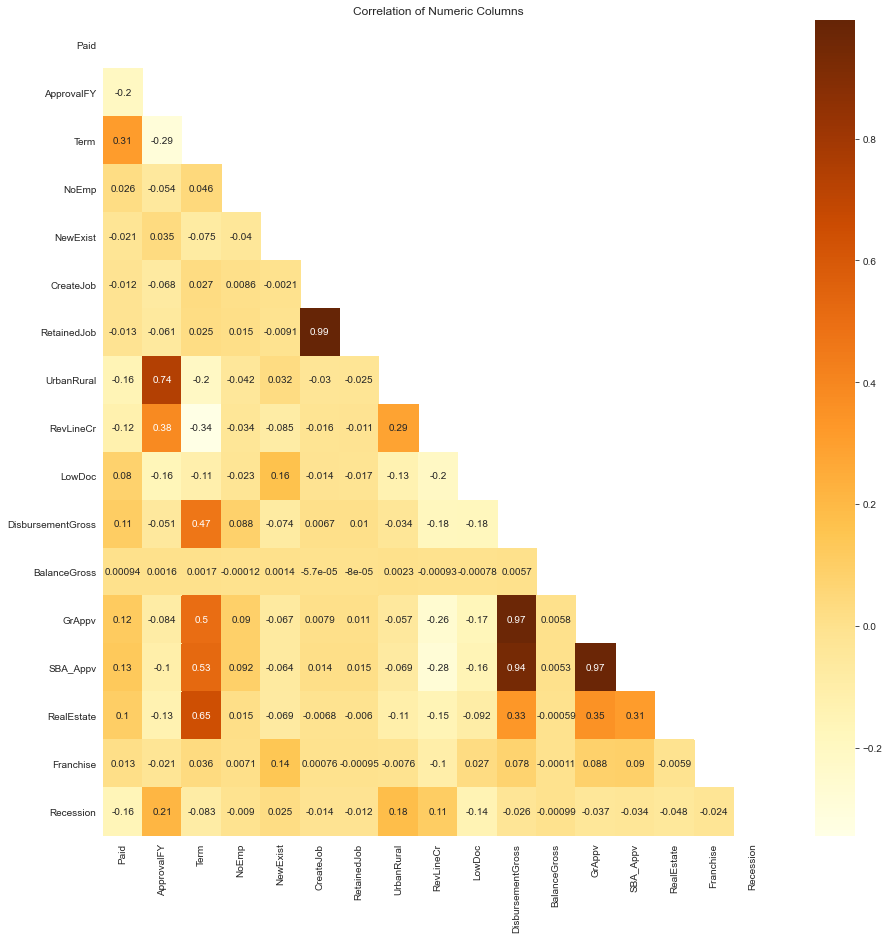

In [15]:
#plotting a correlation matrix of different variables
#saving figures as pdf in general for integrating into the article in Latex.
sns.set_style("whitegrid")
corr = num_cols_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, ax=ax, mask=mask, cmap = "YlOrBr").set(title='Correlation of Numeric Columns')
#plt.savefig('corr_cols.pdf',bbox_inches='tight')
plt.show()

* The best indicators for Paid were Term, SBA_Appv, and GrAppv (.31, .13 and .12 respectively).
* GrAppv has a -.26 correlation with RevLineCr, which means that banks generally approve smaller amounts for businesses that have a revolving line of credit
* RevLineCr has a -.12 correlation with Paid, meaning that businesses with a revolving line of credit were more likely to default. That might explain why Banks are less willing to loan them larger amounts.
* NewExist has a -.021 correlation with Paid. While its only a slightly negative correlation, this still means existing businesses were actually more likely to default on their SBA loans. 
* Term and DisbursementGross have a strong positive correlation (.47), which means that loans with larger terms are usually larger.

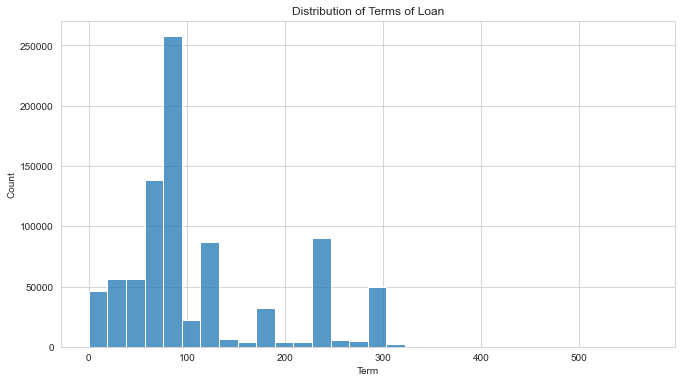

In [16]:
#Since Term and has a high correlation with Paid then would be interesting to see the distribution 

fig = plt.figure(figsize=(11,6))
sns.histplot(data=num_cols_df,x="Term",bins=30)
plt.title('Distribution of Terms of Loan')
plt.ylabel('Count')
plt.show()

The distribution seems not normal, hence would be good to scale it. Spikes near 100, 200 and 300 months

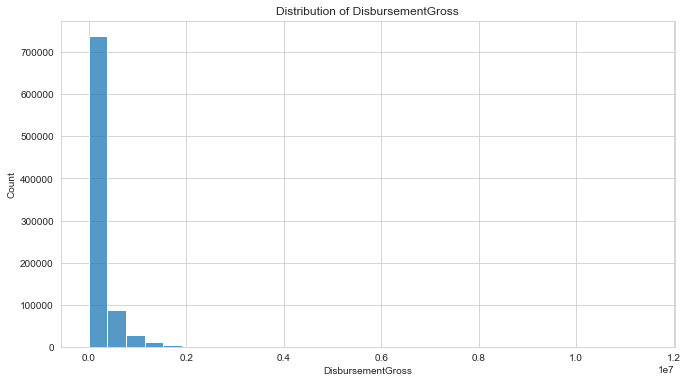

In [17]:
#distribution of DisbursementGross

fig = plt.figure(figsize=(11,6))
sns.histplot(data=num_cols_df,x='DisbursementGross',bins=30)
plt.title('Distribution of DisbursementGross')
plt.ylabel('Count')
plt.show()

Distribution is again skewed and should be scaled logarithmically before modelling. Also SBA_Appv and GrAppv have almost perfect correlation 0.94 and 0.97 respectively hence they will be skewed as well and have to be scaled logarithmically beforehand.

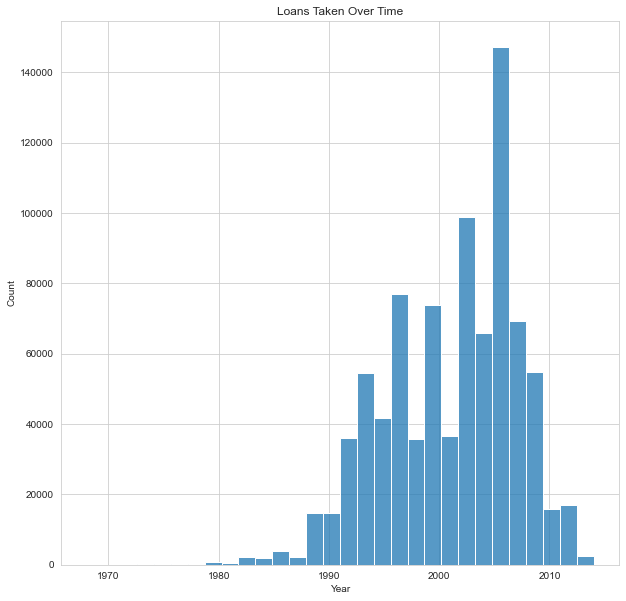

In [18]:
#checking distribution of loan over time
fig = plt.figure(figsize=(10,10))
sns.histplot(data=num_cols_df,x='ApprovalFY',bins=30)
plt.title('Loans Taken Over Time')
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()

Noticed that before 1985 there were quite few or no loans data available in dataset.

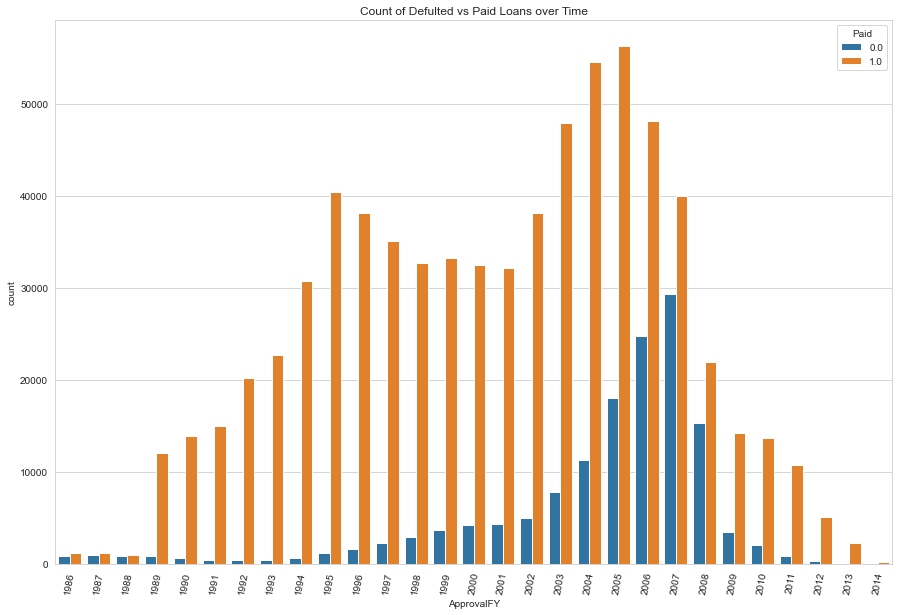

In [19]:
#checking the distribution of paid and unpaid loans wrt. time.
after_1985=df[df['ApprovalFY'] >= 1986]
fig = plt.figure(figsize=(15,10))
sns.countplot(x="ApprovalFY",data=after_1985,hue="Paid")
plt.title('Count of Defulted vs Paid Loans over Time')
plt.xticks(rotation=80)
plt.show()

Effects of financial crisis on defaulted loans. They got decreased.

# Modelling

The columns which will be unnecessary for analysis have to be dropped including the non numerical information. SBA_Appv had highest correlation with Paid column. So it will be used for analysis. Choosing to ignore GrAppv and DisbursementGross, since they are really similar to the SBA_Appv

Classification model is needed to identify if a loan disbursed will default or not. XGboost and LightGBM will be used as ML models to work on the data. They can not handle categorical data hence, encoding is needed to be used on State and Industry (NAICS) and columns based on the default rates.

In [20]:
#dropping unncessary columns
df = df.drop(['LoanNr_ChkDgt','Bank','GrAppv','DisbursementGross','Name', 'City', 'MIS_Status', 'ApprovalDate', 
              'Zip','BankState', 'DisbursementDate','ChgOffPrinGr','BalanceGross'], axis = 1)
print('Columns Dropped')

Columns Dropped


In [21]:
#to fix the skew log of SBA_Appv
df['SBA_Appv'] = np.log(df['SBA_Appv'])
print('Adjusted the scale logarithmically')

Adjusted the scale logarithmically


In [22]:
#Understanding the state columns default rates
state_default = df.groupby(['State','Paid'])['State'].count().unstack('Paid')
state_default['Total SBA Loans Taken'] = state_default[1] + state_default[0]
state_default['PIF Percentage'] = state_default[1]/(state_default[1] + state_default[0])
state_default['Default Percentage'] = (1 - state_default['PIF Percentage'])
state_default = state_default.sort_values(by = 'Default Percentage')
state_default

Paid,0.0,1.0,Total SBA Loans Taken,PIF Percentage,Default Percentage
State,,,,,
MT,584,7948,8532,0.931552,0.068448
WY,193,2579,2772,0.930375,0.069625
VT,392,4941,5333,0.926495,0.073505
ND,395,4759,5154,0.923360,0.076640
SD,339,3983,4322,0.921564,0.078436
ME,556,5226,5782,0.903840,0.096160
NH,1239,10489,11728,0.894355,0.105645
NM,624,5203,5827,0.892912,0.107088
NE,703,5526,6229,0.887141,0.112859


In [23]:
# mapping state default rates

state_def = {'MT':.068, 'WY':.069,'VT':.073,'ND':.076,'SD':.078,'ME':.096,
            'NH':.105,'NM':.107,'NE':.112,'AK':.114,'IA':.115,'MN':.116,
            'RI':.118,'WI':.121,'MA':.127,'KS':.129,'WA':.133,'CT':.136,
            'ID':.141,'PA':.145,'OR':.149,'MO':.151,'HI':.153,'OK':.154,
            'MS':.157,'WV':.162,'OH':.163,'AL':.165,'AR':.167,'IN':.175,
            'UT':.175,'DE':.175,'CA':.177,'CO':.178,'VA':.180,'LA':.181,
            'NC':.184,'TX':.186,'MD':.191,'KY':.192,'SC':.192,'NY':.195,
            'NJ':.195,'AZ':.203,'TN':.206,'MI':.225,'NV':.225,'IL':.225,
            'GA':.227,'DC':.235,'FL':.257}

df['State'] = df['State'].map(state_def)

In [24]:
#cleaning NAICS by choosing first two digits, since they are identifier for the Industry types.
df['NAICS'] = df['NAICS'].astype(str)
def first_two(string):
    s = string[:2]
    return s
df['NAICS'] = df['NAICS'].apply(lambda x: first_two(x))

In [25]:
#mapping the Industry names to the NAICS code, we have this information in the original SBA dataset provided
dic = {'11': 'Agriculture, Fishing, Forestry, and Hunting',
      '21': 'Mining, Quarrying, Oil and Gas Extraction',
      '22': 'Utilities', '23': 'Construction', '31':'Manufacturing',
      '32': 'Manufacturing', '33': 'Manufacturing', '42': 'Wholesale Trade',
      '44': 'Retail Trade', '45':'Retail Trade', '48':'Transport and Warehouse',
      '49': 'Transport and Warehouse', '51':'Information',
      '52': 'Finance and Insurance', '53':'Real Estate and Rental Leasing',
      '54':'Profesisonal, Scientific, and Technical Services',
      '55':'Management', '56':'Administrative and Support and Waste Management',
      '61':'Educational Services', '62':'Health Care and Social Assistance',
      '71': 'Arts, Entertainment and Recreation', '72':'Accomodation and Food Services',
      '81': 'Other Services', '92':'Public Administration'}

df['NAICS'] = df['NAICS'].map(dic)

In [26]:
#Understanding the Industry columns default rates
Ind_default = df.groupby(['NAICS','Paid'])['NAICS'].count().unstack('Paid')
Ind_default['Total SBA Loans Taken'] = Ind_default[1] + Ind_default[0]
Ind_default['PIF Percentage'] = Ind_default[1]/(Ind_default[1] + Ind_default[0])
Ind_default['Default Percentage'] = (1 - Ind_default['PIF Percentage'])
Ind_default = Ind_default.sort_values(by ='Default Percentage')
Ind_default

Paid,0.0,1.0,Total SBA Loans Taken,PIF Percentage,Default Percentage
NAICS,,,,,
"Mining, Quarrying, Oil and Gas Extraction",150,1652,1802,0.916759,0.083241
"Agriculture, Fishing, Forestry, and Hunting",792,8024,8816,0.910163,0.089837
Management,25,230,255,0.901961,0.098039
Health Care and Social Assistance,5445,48297,53742,0.898683,0.101317
Utilities,88,554,642,0.862928,0.137072
Manufacturing,9853,55845,65698,0.850026,0.149974
Public Administration,34,184,218,0.844037,0.155963
"Profesisonal, Scientific, and Technical Services",11982,53032,65014,0.815701,0.184299
Wholesale Trade,8761,38005,46766,0.812663,0.187337


In [27]:
#mapping the default rates to the NAICS column
ind_def = {'Accomodation and Food Services':.217,'Administrative and Support and Waste Management':.225,
          'Agriculture, Fishing, Forestry, and Hunting':.089,'Arts, Entertainment and Recreatiom':.202,
          'Construction':.227,'Educational Services':.236,'Finance and Insurance':.276,
          'Health Care and Social Assistance':.101,'Information':.242,'Management':.098,
          'Manufacturing':.149,'Mining, Quarrying, Oil and Gas Extraction':.083,
          'Other Services':.191,'Profesisonal, Scientific, and Technical Services':.184,
          'Public Administration':.155,'Real Estate and Rental Leasing':.279,
          'Retail Trade':.222,'Transport and Warehouse':.258,'Utilities':.137,
          'Wholesale Trade':.187}

df['NAICS'] = df['NAICS'].map(ind_def)

In [28]:
#Renaming the column names to identify the transformed/encoded columns based on default rates
df = df.rename(columns={'State':'State Default Rate','NAICS':'Industry Default Rate'})

In [30]:
y = df['Paid']
x = df.drop(['Paid'], axis = 1)
train_X, test_X, train_y, test_y = train_test_split(x, y, train_size=0.8 ,random_state = 101)
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)
print('Train/test data splitted and transformed for analysis')

Train/test data splitted and transformed for analysis


In [33]:
LGBM_Model = lgb.LGBMClassifier(random_state=101,learning_rate=0.01,max_depth=-1,min_data_in_leaf=60,num_iterations=200,num_leaves=70)
LGBM_Model.fit(train_X,train_y)
PredictionLGBM = LGBM_Model.predict(test_X)
print('LGBM Model Trained')

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
LGBM Model Trained


In [35]:
score_auc = (accuracy_score(test_y,PredictionLGBM) * 100)
print('Accuracy: %r' % round(score_auc,2), '%')
score_prec = (precision_score(test_y,PredictionLGBM) * 100)
print('Precision: %r' % round(score_prec,2), '%')
score_rec = (recall_score(test_y,PredictionLGBM) * 100)
print('Recall: %r' % round(score_rec,2), '%')
score_f1 = (f1_score(test_y,PredictionLGBM) * 100)
print('F1 Score: %r' % round(score_f1,2), '%')

Accuracy: 94.03 %
Precision: 95.24 %
Recall: 97.7 %
F1 Score: 96.45 %


Doing Feature importance for the model

In [36]:
score = pd.DataFrame(LGBM_Model.feature_importances_, columns=['Score'])
score['Column'] = x.columns
score.head()

,Score,Column
0,532,State Default Rate
1,99,Industry Default Rate
2,2757,ApprovalFY
3,7958,Term
4,155,NoEmp


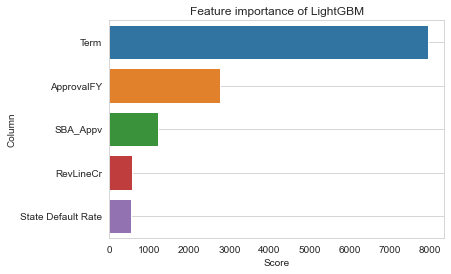

In [37]:
# Make plot of top 5 feature importances
new_score = score.sort_values(by='Score',ascending=False).head(5)
sns.barplot(data=new_score[:10],x='Score',y='Column')
plt.title('Feature importance of LightGBM')
plt.grid(b=None,axis='both')
#plt.savefig('lgm_fi.pdf',bbox_inches='tight')

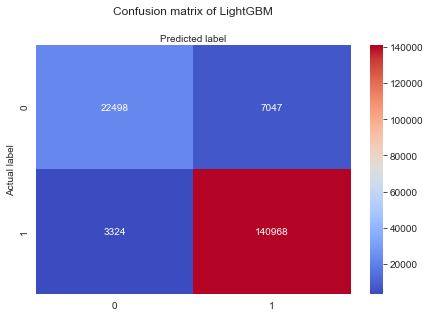

In [38]:
#Confusion matrix for the model
cnf_matrix = confusion_matrix(test_y, PredictionLGBM)

class_names = [0, 1]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of LightGBM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('conf_lgb.pdf',bbox_inches='tight')
plt.show()

In [39]:
model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,\
                          #n_jobs=-1,learning_rate=0.3)
model.fit(train_X, train_y)
PredictionXGB=model.predict(test_X)

In [40]:
score_auc = (accuracy_score(test_y,PredictionXGB) * 100)
print('Accuracy: %r' % round(score_auc,2), '%')
score_prec = (precision_score(test_y,PredictionXGB) * 100)
print('Precision: %r' % round(score_prec,2), '%')
score_rec = (recall_score(test_y,PredictionXGB) * 100)
print('Recall: %r' % round(score_rec,2), '%')
score_f1 = (f1_score(test_y,PredictionXGB) * 100)
print('F1 Score: %r' % round(score_f1,2), '%')

Accuracy: 92.88 %
Precision: 94.46 %
Recall: 97.12 %
F1 Score: 95.77 %


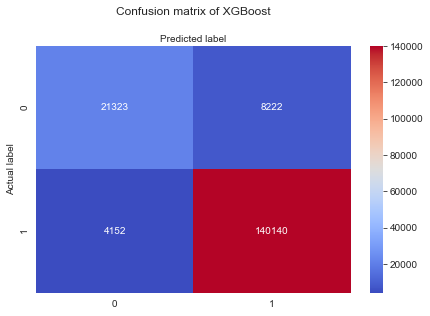

In [41]:
#confusion matrix of xgbm
cnf_matrix = confusion_matrix(test_y, PredictionXGB) #y_pred

class_names = [0, 1]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of XGBoost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('conf_xgb.pdf',bbox_inches='tight')
plt.show()

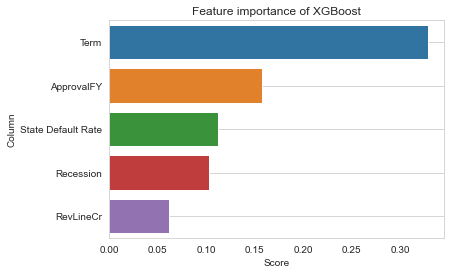

In [42]:
#plotting feature importance
score = pd.DataFrame(model.feature_importances_, columns=['Score'])
score['Column'] = x.columns
score.head()

# Make plot feature importances
new_score = score.sort_values(by='Score',ascending=False).head(5)
sns.barplot(data=new_score[:10],x='Score',y='Column')
plt.title('Feature importance of XGBoost')
plt.grid(b=None,axis='both')
#plt.savefig('xgb_fi.pdf',bbox_inches='tight')

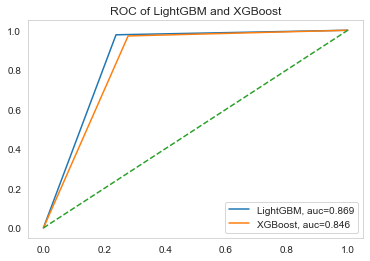

In [49]:
#plotting ROC curve

plt.figure(0).clf()
fpr, tpr, thresh = roc_curve(test_y, PredictionLGBM)
auc = roc_auc_score(test_y, PredictionLGBM)
plt.plot(fpr,tpr,label="LightGBM, auc="+str(round(auc,3)))

fpr, tpr, thresh = roc_curve(test_y, PredictionXGB)
auc = roc_auc_score(test_y, PredictionXGB)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(round(auc,3)))
plt.plot([0,1],[0,1],'--')
plt.title('ROC of LightGBM and XGBoost')
plt.grid(b=None)
plt.legend(loc=0)
#plt.savefig('roc.pdf')

plt.show()

Details of the analysis have been put in the article.

Final Note: some attributes such as AUC score for XGBoost changed after repeating the steps on Jupyter notebook. So values might vary.

# END